In [1]:
# Importing my libraries

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# Import churn data csv [In-text citation: Middleton, K. (n.d.). Dr. Middleton PA Step-by-Step Guide (NBM3).]
df = pd.read_csv('churn_clean.csv', keep_default_na=False)

# Check the database info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

## C1: Data Cleaning

In [2]:
# Updating columns with names that fit within python casing expectations
updated_names = {
    'CaseOrder': 'case_order',
    'Customer_id': 'customer_id', 
    'Interaction': 'interaction', 
    'UID': 'uid', 
    'City': 'city', 
    'State': 'state', 
    'County': 'county', 
    'Zip': 'zip_code', 
    'Lat': 'latitude', 
    'Lng': 'longitude', 
    'Population': 'population', 
    'TimeZone': 'timezone', 
    'Children': 'children',
    'Area': 'area_type',
    'Job': 'job_title',
    'Age': 'age',
    'Income': 'income',
    'Marital': 'marital_status',
    'Gender': 'gender',
    'Churn': 'churn',
    'Outage_sec_perweek': 'outage_sec_perweek',
    'Email': 'email',
    'Contacts': 'tech_support_contacts',
    'Yearly_equip_failure': 'yearly_equip_failure',
    'Techie': 'techie',
    'Contract': 'contract',
    'Port_modem': 'port_modem',
    'Tablet': 'tablet',
    'InternetService': 'internet_service',
    'Phone': 'phone_service',
    'Multiple': 'multiple_lines',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'Tenure': 'tenure',
    'MonthlyCharge': 'monthly_charge',
    'Bandwidth_GB_Year': 'bandwidth_gb_year',
    'Item1': 'srv1_timely_response',
    'Item2': 'srv2_timely_fixes',
    'Item3': 'srv3_timely_replacements',
    'Item4': 'srv4_reliability',
    'Item5': 'srv5_options',
    'Item6': 'srv6_respectful_response',
    'Item7': 'srv7_courteous_exchange',
    'Item8': 'srv8_staff_listening'}
df.rename(columns=updated_names, inplace=True)

In [3]:
# dropping initial columns that I do not plan to include in my analysis
df = df.drop(columns=['case_order', 'customer_id', 'interaction', 'uid', 'city', 'state', 'county', 'zip_code', 'latitude', 'longitude', 'population', 'children', 'timezone', 'job_title', 'marital_status', 'tablet', 'email', 'payment_method', 'paperless_billing', 'srv1_timely_response', 'srv2_timely_fixes', 'srv3_timely_replacements', 'srv4_reliability', 'srv5_options', 'srv6_respectful_response', 'srv7_courteous_exchange', 'srv8_staff_listening'])

In [4]:
# Checking for null values
df_null = df.isnull().sum()
df_null

area_type                0
age                      0
income                   0
gender                   0
churn                    0
outage_sec_perweek       0
tech_support_contacts    0
yearly_equip_failure     0
techie                   0
contract                 0
port_modem               0
internet_service         0
phone_service            0
multiple_lines           0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
tenure                   0
monthly_charge           0
bandwidth_gb_year        0
dtype: int64

In [5]:
# Check for outliers
with pd.option_context('display.max_columns', 40):
    print(df.describe(include = [np.number]))
    pd.reset_option('display.max_columns')

                age         income  outage_sec_perweek  tech_support_contacts  \
count  10000.000000   10000.000000        10000.000000           10000.000000   
mean      53.078400   39806.926771           10.001848               0.994200   
std       20.698882   28199.916702            2.976019               0.988466   
min       18.000000     348.670000            0.099747               0.000000   
25%       35.000000   19224.717500            8.018214               0.000000   
50%       53.000000   33170.605000           10.018560               1.000000   
75%       71.000000   53246.170000           11.969485               2.000000   
max       89.000000  258900.700000           21.207230               7.000000   

       yearly_equip_failure        tenure  monthly_charge  bandwidth_gb_year  
count          10000.000000  10000.000000    10000.000000       10000.000000  
mean               0.398000     34.526188      172.624816        3392.341550  
std                0.635953     2

In [6]:
# Grouping my numeric independent variables
ind_num = df.select_dtypes(exclude = ['object'])
ind_num

,age,income,outage_sec_perweek,tech_support_contacts,yearly_equip_failure,tenure,monthly_charge,bandwidth_gb_year
0,68,28561.99,7.978323,0,1,6.795513,172.455519,904.536110
1,27,21704.77,11.699080,0,1,1.156681,242.632554,800.982766
2,50,9609.57,10.752800,0,1,15.754144,159.947583,2054.706961
3,48,18925.23,14.913540,2,0,17.087227,119.956840,2164.579412
4,83,40074.19,8.147417,2,1,1.670972,149.948316,271.493436
...,...,...,...,...,...,...,...,...
9995,23,55723.74,9.415935,2,0,68.197130,159.979400,6511.252601
9996,48,34129.34,6.740547,2,0,61.040370,207.481100,5695.951810
9997,48,45983.43,6.590911,0,0,47.416890,169.974100,4159.305799
9998,39,16667.58,12.071910,1,0,71.095600,252.624000,6468.456752


In [7]:
# Grouping my categorical independent variables
ind_cat = df.select_dtypes(exclude = ['float64', 'int64']).drop(columns=['churn'])
ind_cat

,area_type,gender,techie,contract,port_modem,internet_service,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,Urban,Male,No,One year,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes
1,Urban,Female,Yes,Month-to-month,No,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes
2,Urban,Female,Yes,Two Year,Yes,DSL,Yes,Yes,No,No,No,No,No,Yes
3,Suburban,Male,Yes,Two Year,No,DSL,Yes,No,Yes,No,No,No,Yes,No
4,Suburban,Male,No,Month-to-month,Yes,Fiber Optic,No,No,No,No,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rural,Male,No,Month-to-month,Yes,DSL,Yes,Yes,No,Yes,Yes,No,No,No
9996,Rural,Male,No,Two Year,No,Fiber Optic,Yes,Yes,Yes,Yes,Yes,No,Yes,No
9997,Rural,Female,No,Month-to-month,No,Fiber Optic,Yes,Yes,Yes,Yes,No,No,No,No
9998,Urban,Male,No,Two Year,No,Fiber Optic,No,Yes,No,No,No,Yes,Yes,Yes


## C2: Summary Statistics

In [8]:
# Dependent variable value summary
df['churn'].value_counts()

churn
No     7350
Yes    2650
Name: count, dtype: int64

In [9]:
# Value summary for categorical variables
# Viewing the summary stats for categorical independent variables
vc_list = []
for col in ind_cat.columns:
    counts = ind_cat[col].value_counts().to_dict()
    vc_list.append({col: counts})

vc_list

[{'area_type': {'Suburban': 3346, 'Urban': 3327, 'Rural': 3327}},
 {'gender': {'Female': 5025, 'Male': 4744, 'Nonbinary': 231}},
 {'techie': {'No': 8321, 'Yes': 1679}},
 {'contract': {'Month-to-month': 5456, 'Two Year': 2442, 'One year': 2102}},
 {'port_modem': {'No': 5166, 'Yes': 4834}},
 {'internet_service': {'Fiber Optic': 4408, 'DSL': 3463, 'None': 2129}},
 {'phone_service': {'Yes': 9067, 'No': 933}},
 {'multiple_lines': {'No': 5392, 'Yes': 4608}},
 {'online_security': {'No': 6424, 'Yes': 3576}},
 {'online_backup': {'No': 5494, 'Yes': 4506}},
 {'device_protection': {'No': 5614, 'Yes': 4386}},
 {'tech_support': {'No': 6250, 'Yes': 3750}},
 {'streaming_tv': {'No': 5071, 'Yes': 4929}},
 {'streaming_movies': {'No': 5110, 'Yes': 4890}}]

In [10]:
# Summary stats for quantitative variables
print(ind_num.describe())

                age         income  outage_sec_perweek  tech_support_contacts  \
count  10000.000000   10000.000000        10000.000000           10000.000000   
mean      53.078400   39806.926771           10.001848               0.994200   
std       20.698882   28199.916702            2.976019               0.988466   
min       18.000000     348.670000            0.099747               0.000000   
25%       35.000000   19224.717500            8.018214               0.000000   
50%       53.000000   33170.605000           10.018560               1.000000   
75%       71.000000   53246.170000           11.969485               2.000000   
max       89.000000  258900.700000           21.207230               7.000000   

       yearly_equip_failure        tenure  monthly_charge  bandwidth_gb_year  
count          10000.000000  10000.000000    10000.000000       10000.000000  
mean               0.398000     34.526188      172.624816        3392.341550  
std                0.635953     2

## C3: Univariate & Bivariate Statistics

In [11]:
# ignoring FutureWarnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Univariate Visualizations

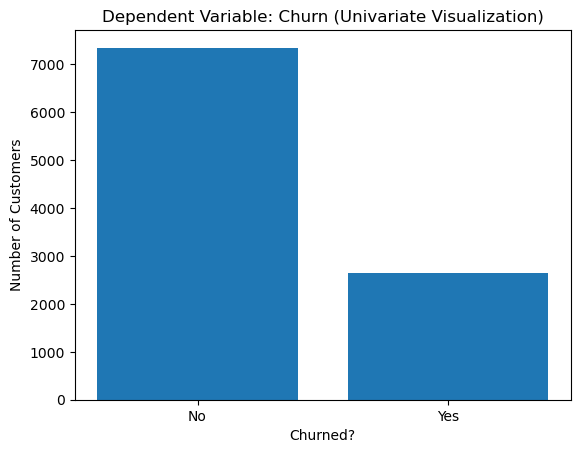

In [12]:
# Visualizing my categorical dependent (target) variable using a bar graph
plt.title('Dependent Variable: Churn (Univariate Visualization)')
churn_counts = df['churn'].value_counts()
churn_labels = ['No', 'Yes']
plt.bar(churn_counts.index, churn_counts.values)
plt.xlabel('Churned?')
plt.ylabel('Number of Customers')
plt.xticks(ticks=range(len(churn_labels)), labels=churn_labels);

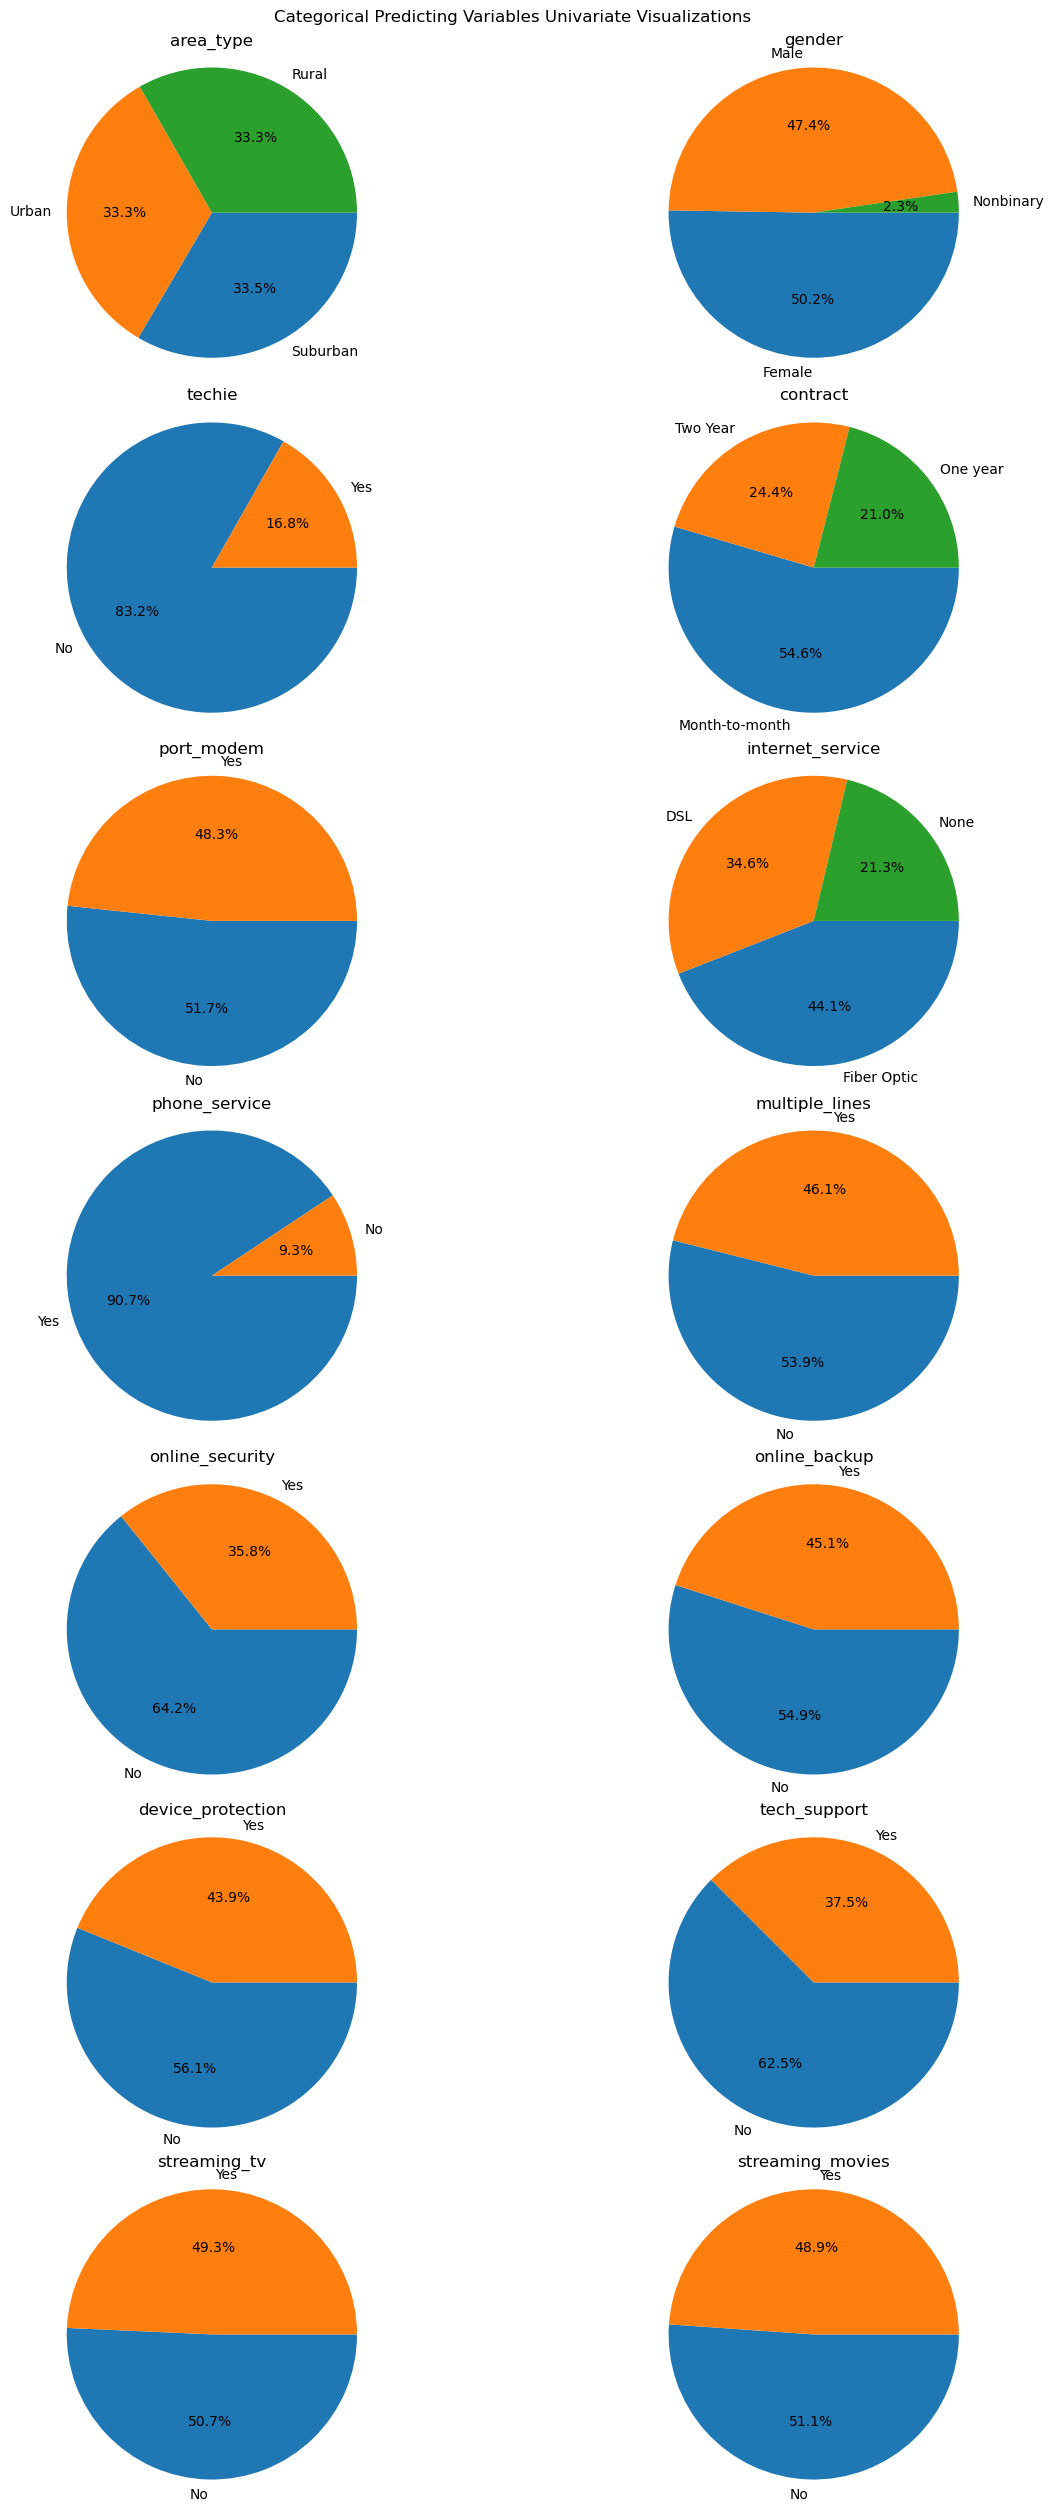

In [13]:
# Pie chart visualizations for categorical independent (predicting) variables
fig, axes = plt.subplots(7, 2, sharex=False, sharey=False, figsize=(12, 25), constrained_layout=True)

for col, ax in zip(ind_cat.columns, axes.flat):
    plt.suptitle('Categorical Predicting Variables Univariate Visualizations')
    categorical_counts = ind_cat[col].value_counts()
    ax.pie(categorical_counts, labels=categorical_counts.index, autopct='%1.1f%%', counterclock=False)
    ax.set_title(col)
    ax.axis('square')

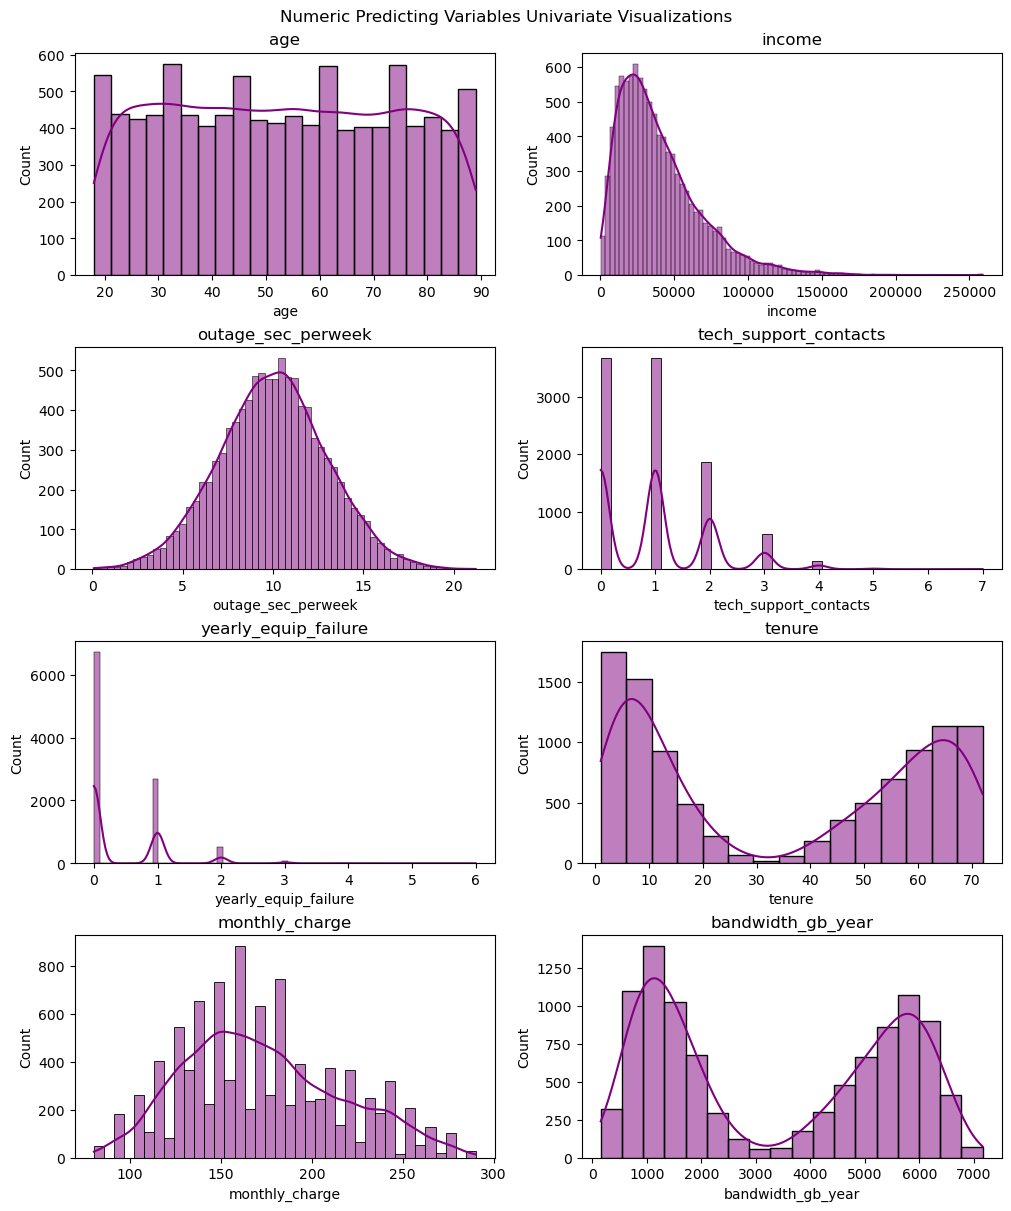

In [14]:
# Histogram visualizations for my numeric independent (predicting) variables
fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(10, 12), constrained_layout=True)

for col, ax in zip(ind_num.columns, axes.flat):
    plt.suptitle('Numeric Predicting Variables Univariate Visualizations')
    sns.histplot(ind_num[col], ax=ax, color='purple', kde=True)
    ax.set_title(col)

### Bivariate Visualizations

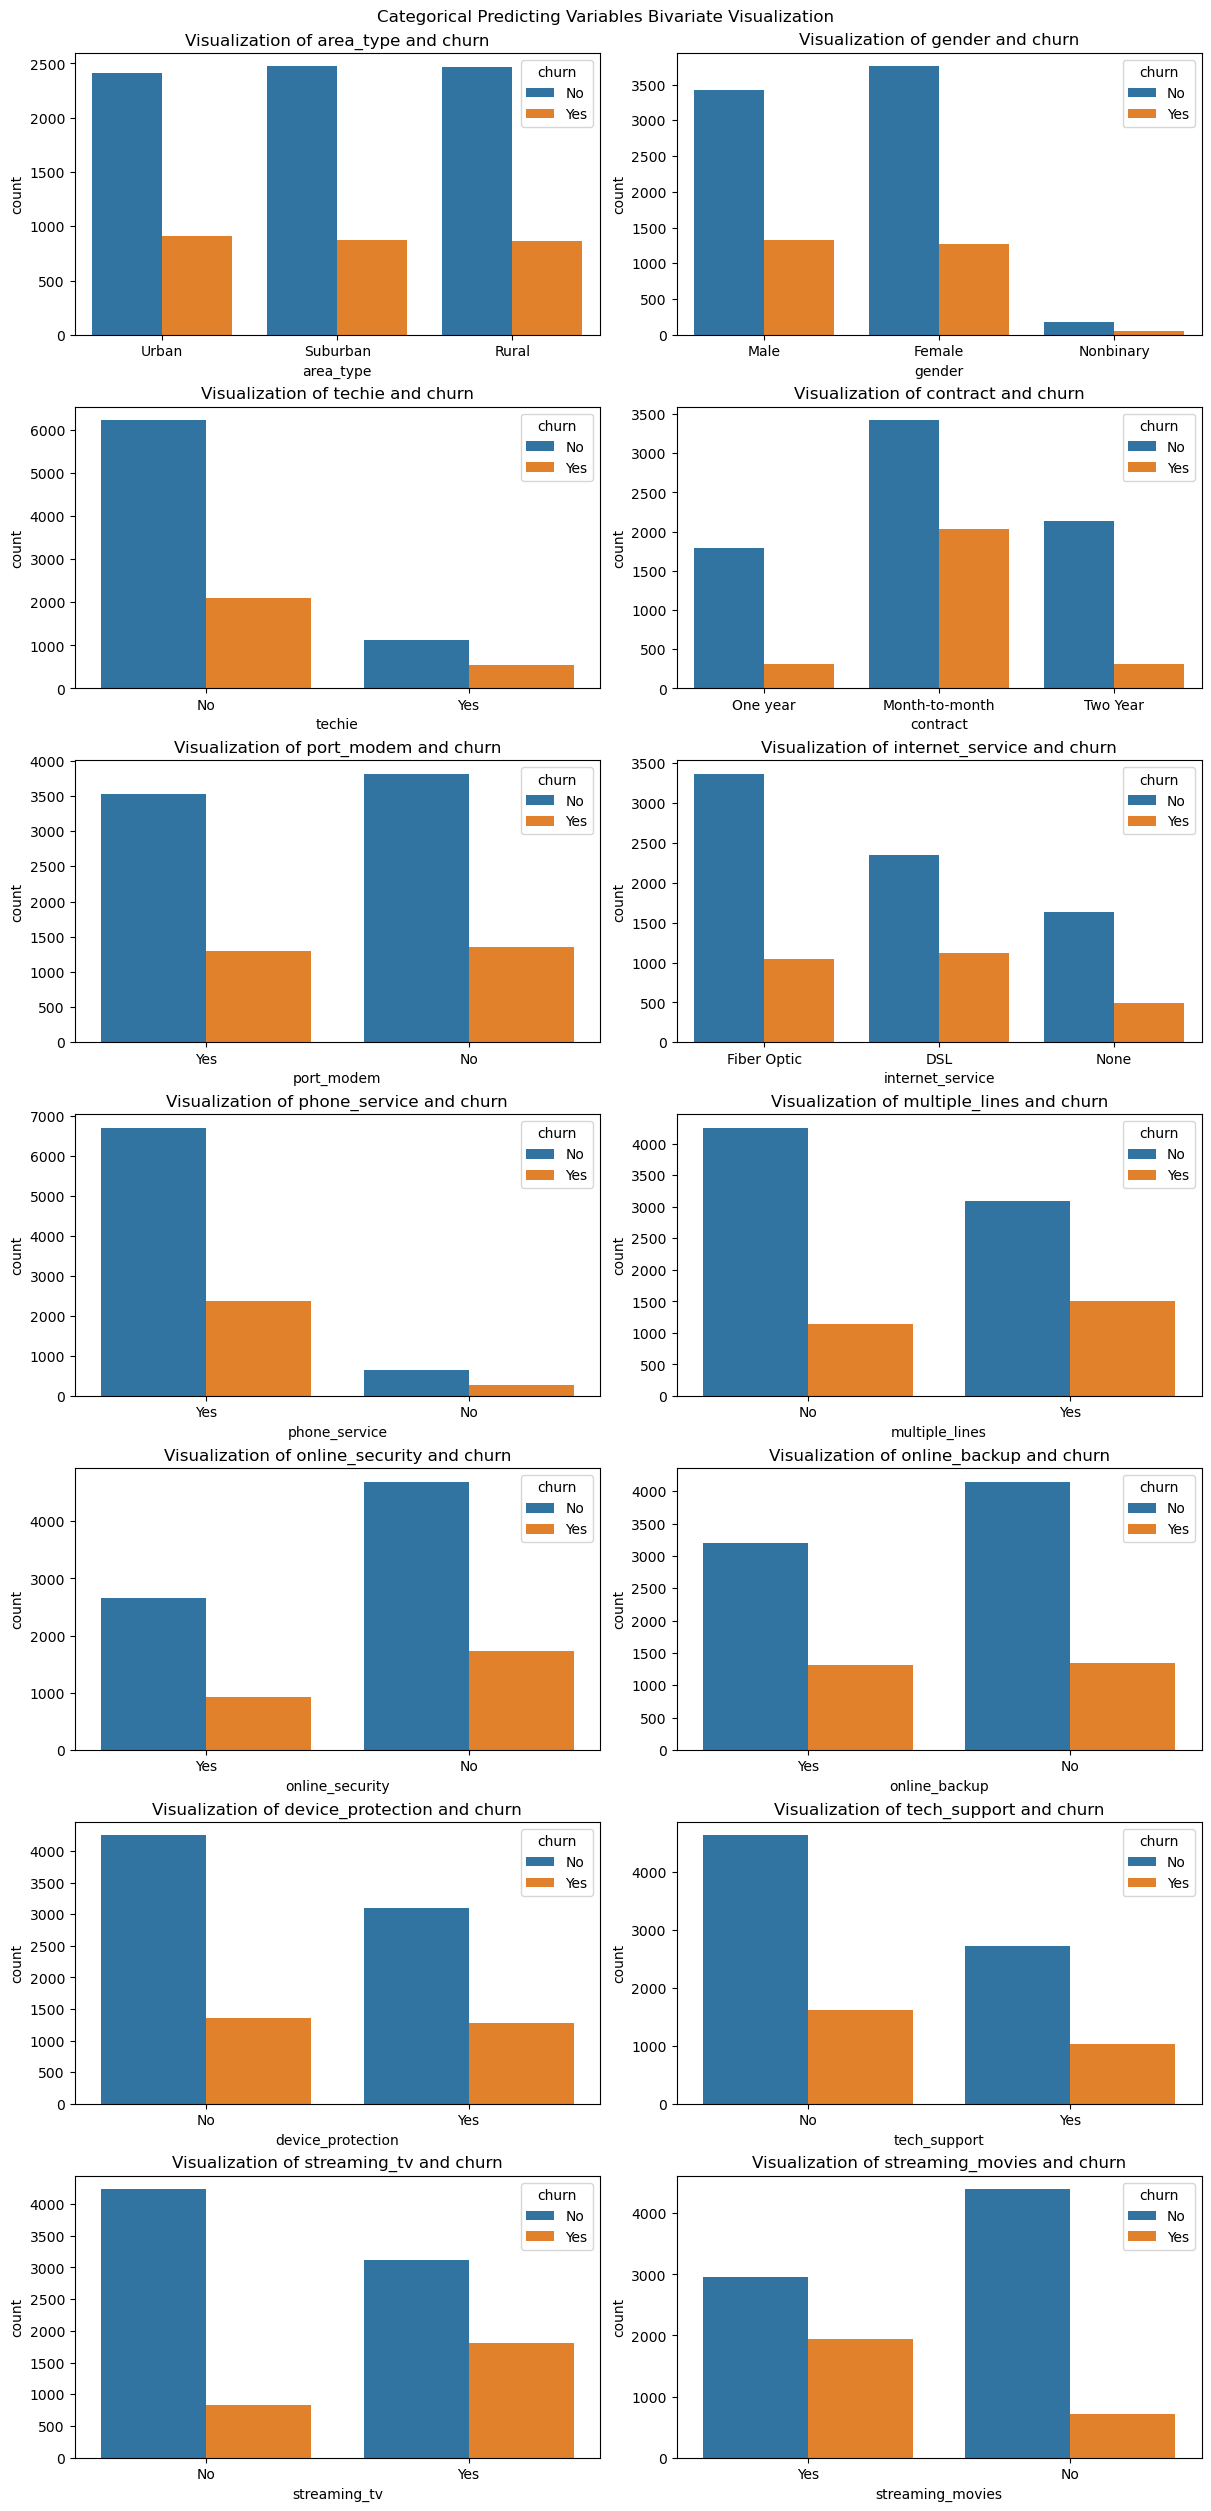

In [15]:
# Countplot visualizations for the relationship between my dependent variable and categorical independent variables
fig, axes = plt.subplots(7, 2, sharex=False, sharey=False, figsize=(12, 25), constrained_layout=True)

for col, ax in zip(ind_cat.columns, axes.flat):
    plt.suptitle('Categorical Predicting Variables Bivariate Visualization')
    sns.countplot(x=ind_cat[col], hue=df['churn'], ax=ax)
    ax.set_title(f'Visualization of {col} and churn')

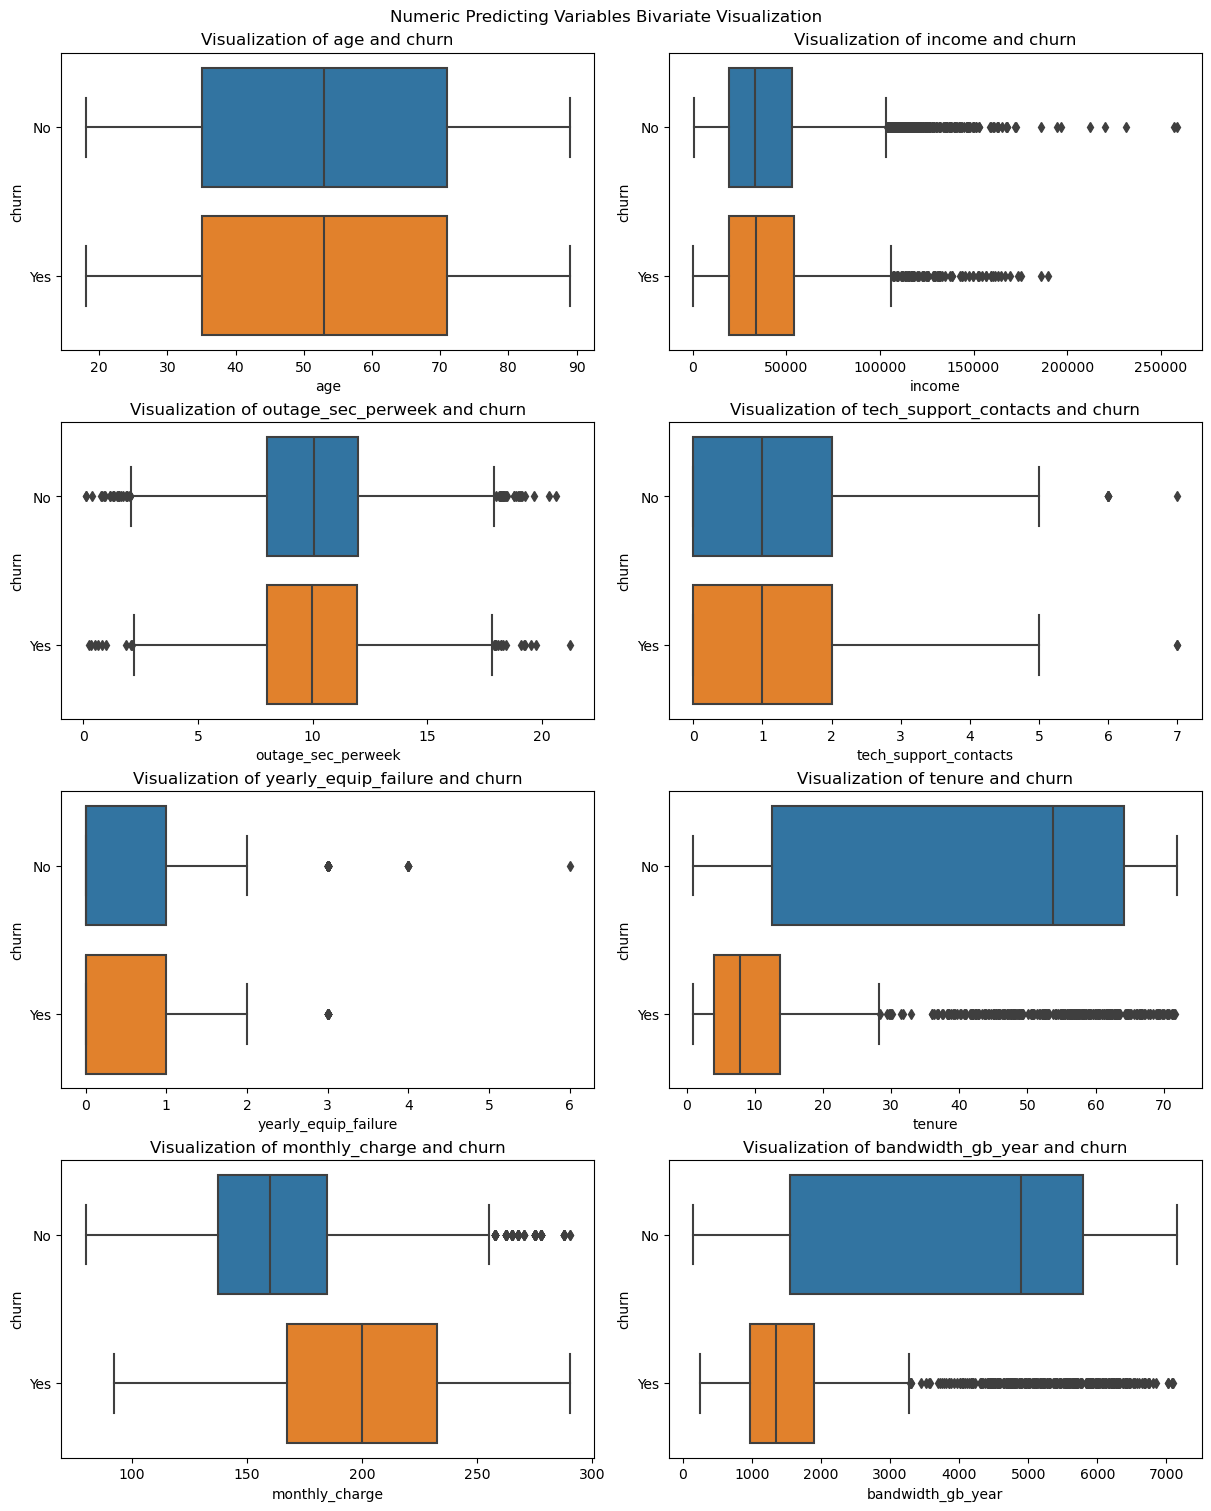

In [17]:
# Boxplot visualizations for the relationship between my dependent variable and quantitative independent variables
fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(12, 15), constrained_layout=True)

for col, ax in zip(ind_num.columns, axes.flat):
    plt.suptitle('Numeric Predicting Variables Bivariate Visualization')
    sns.boxplot(x=ind_num[col], y=df['churn'], ax=ax)
    ax.set_title(f'Visualization of {col} and churn')

## C4: Data Transformation

In [18]:
# Inspecting categorical independent variables
ind_cat

,area_type,gender,techie,contract,port_modem,internet_service,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,Urban,Male,No,One year,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes
1,Urban,Female,Yes,Month-to-month,No,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes
2,Urban,Female,Yes,Two Year,Yes,DSL,Yes,Yes,No,No,No,No,No,Yes
3,Suburban,Male,Yes,Two Year,No,DSL,Yes,No,Yes,No,No,No,Yes,No
4,Suburban,Male,No,Month-to-month,Yes,Fiber Optic,No,No,No,No,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rural,Male,No,Month-to-month,Yes,DSL,Yes,Yes,No,Yes,Yes,No,No,No
9996,Rural,Male,No,Two Year,No,Fiber Optic,Yes,Yes,Yes,Yes,Yes,No,Yes,No
9997,Rural,Female,No,Month-to-month,No,Fiber Optic,Yes,Yes,Yes,Yes,No,No,No,No
9998,Urban,Male,No,Two Year,No,Fiber Optic,No,Yes,No,No,No,Yes,Yes,Yes


In [19]:
# Encoding binary categorical variables (dependent and independent variables)
binary_cat = ['churn', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df[binary_cat] = df[binary_cat].replace({'No': 0, 'Yes': 1})

In [20]:
# One hot encoding the rest of my independent categorical
df = pd.get_dummies(df, columns=['area_type', 'gender', 'contract', 'internet_service'], drop_first=True)

df

,age,income,churn,outage_sec_perweek,tech_support_contacts,yearly_equip_failure,techie,port_modem,phone_service,multiple_lines,...,monthly_charge,bandwidth_gb_year,area_type_Suburban,area_type_Urban,gender_Male,gender_Nonbinary,contract_One year,contract_Two Year,internet_service_Fiber Optic,internet_service_None
0,68,28561.99,0,7.978323,0,1,0,1,1,0,...,172.455519,904.536110,False,True,True,False,True,False,True,False
1,27,21704.77,1,11.699080,0,1,1,0,1,1,...,242.632554,800.982766,False,True,False,False,False,False,True,False
2,50,9609.57,0,10.752800,0,1,1,1,1,1,...,159.947583,2054.706961,False,True,False,False,False,True,False,False
3,48,18925.23,0,14.913540,2,0,1,0,1,0,...,119.956840,2164.579412,True,False,True,False,False,True,False,False
4,83,40074.19,1,8.147417,2,1,0,1,0,0,...,149.948316,271.493436,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23,55723.74,0,9.415935,2,0,0,1,1,1,...,159.979400,6511.252601,False,False,True,False,False,False,False,False
9996,48,34129.34,0,6.740547,2,0,0,0,1,1,...,207.481100,5695.951810,False,False,True,False,False,True,True,False
9997,48,45983.43,0,6.590911,0,0,0,0,1,1,...,169.974100,4159.305799,False,False,False,False,False,False,True,False
9998,39,16667.58,0,12.071910,1,0,0,0,0,1,...,252.624000,6468.456752,False,True,True,False,False,True,True,False


In [21]:
# converting my dummy variable values into numeric values
dummies = ['area_type_Suburban', 'area_type_Urban', 'gender_Male', 'gender_Nonbinary', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']
df[dummies] = df[dummies].astype('int64')

df

,age,income,churn,outage_sec_perweek,tech_support_contacts,yearly_equip_failure,techie,port_modem,phone_service,multiple_lines,...,monthly_charge,bandwidth_gb_year,area_type_Suburban,area_type_Urban,gender_Male,gender_Nonbinary,contract_One year,contract_Two Year,internet_service_Fiber Optic,internet_service_None
0,68,28561.99,0,7.978323,0,1,0,1,1,0,...,172.455519,904.536110,0,1,1,0,1,0,1,0
1,27,21704.77,1,11.699080,0,1,1,0,1,1,...,242.632554,800.982766,0,1,0,0,0,0,1,0
2,50,9609.57,0,10.752800,0,1,1,1,1,1,...,159.947583,2054.706961,0,1,0,0,0,1,0,0
3,48,18925.23,0,14.913540,2,0,1,0,1,0,...,119.956840,2164.579412,1,0,1,0,0,1,0,0
4,83,40074.19,1,8.147417,2,1,0,1,0,0,...,149.948316,271.493436,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23,55723.74,0,9.415935,2,0,0,1,1,1,...,159.979400,6511.252601,0,0,1,0,0,0,0,0
9996,48,34129.34,0,6.740547,2,0,0,0,1,1,...,207.481100,5695.951810,0,0,1,0,0,1,1,0
9997,48,45983.43,0,6.590911,0,0,0,0,1,1,...,169.974100,4159.305799,0,0,0,0,0,0,1,0
9998,39,16667.58,0,12.071910,1,0,0,0,0,1,...,252.624000,6468.456752,0,1,1,0,0,1,1,0


## C5: Data CSV File

In [22]:
#Saving the cleaned data in a CSV file
df.to_csv('clean_churn_data_2.csv', index=False)

## D1: Initial Logistic Regression Model

In [23]:
#Constructing an initial logistic regression model

#Setting the target variable
y = df.churn

#Setting my independent variables
X = df[['age', 'income', 'outage_sec_perweek', 'tech_support_contacts', 'yearly_equip_failure', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'area_type_Urban', 'gender_Male', 'gender_Nonbinary', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219756
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9973
Method:                           MLE   Df Model:                           26
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:30:09   Log-Likelihood:                -2197.6
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.798      0.425      -0.003       0.008
income                        6.426e-07   1.36e-06      0.472      0.637   -2.03e-06    3.31e-06
outage_sec_perweek              -0.0023      0.013     -0.180      0.858      -0.028       0.023
tech_support_contacts            0.0550      0.039      1.427      0.154      -0.021       0.131
yearly_equip_failure            -0.0312      0.061     -0.514      0.607      -0.150       0.088
techie                           1.0911      0.102     10.717      0.000       0.892       1.291
port_modem                       0.1330      0.077      1.732      0.083      -0.018       0.284
phone_service                   -0.2847      0.131     -2.171      0.030      -0.542      -0.028
multiple_lines                   0.3591      0.172      2.086      0.037       0.022       0.697
online_security                 -0.2703      0.090     -2.993      0.003      -0.447      -0.093
online_backup                   -0.1079      0.130     -0.827      0.408      -0.364       0.148
device_protection               -0.0896      0.101     -0.888      0.374      -0.287       0.108
tech_support                    -0.2196      0.101     -2.172      0.030      -0.418      -0.021
streaming_tv                     1.1334      0.228      4.976      0.000       0.687       1.580
streaming_movies                 1.2980      0.264      4.916      0.000       0.781       1.815
tenure                          -0.1546      0.048     -3.234      0.001      -0.248      -0.061
monthly_charge                   0.0387      0.005      7.688      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.833      0.405      -0.001       0.002
area_type_Suburban              -0.0561      0.095     -0.592      0.554      -0.242       0.130
area_type_Urban                  0.0394      0.094      0.421      0.674      -0.144       0.223
gender_Male                      0.2394      0.086      2.787      0.005       0.071       0.408
gender_Nonbinary                -0.0841      0.261     -0.322      0.748      -0.596       0.428
contract_One year               -3.3793      0.128    -26.466      0.000      -3.630      -3.129
contract_Two Year               -3.4564      0.125    -27.683      0.000      -3.701      -3.212
internet_service_Fiber Optic    -1.9376      0.306     -6.337      0.000      -2.537      -1.338
internet_service_None           -0.7361      0.250     -2.949      0.003      -1.225      -0.247
const                           -4.9199      0.510     -9.650      0.000      -5.919      -3.921
================================================================================================
"""

## D2: Model Reduction Justification

In [24]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing outage_sec_perweek
y = df.churn
X = df[['age', 'income', 'tech_support_contacts', 'yearly_equip_failure', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'area_type_Urban', 'gender_Male', 'gender_Nonbinary', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219758
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9974
Method:                           MLE   Df Model:                           25
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:31:02   Log-Likelihood:                -2197.6
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.800      0.424      -0.003       0.008
income                        6.432e-07   1.36e-06      0.472      0.637   -2.03e-06    3.31e-06
tech_support_contacts            0.0548      0.039      1.422      0.155      -0.021       0.130
yearly_equip_failure            -0.0313      0.061     -0.516      0.606      -0.150       0.088
techie                           1.0911      0.102     10.717      0.000       0.892       1.291
port_modem                       0.1330      0.077      1.732      0.083      -0.018       0.284
phone_service                   -0.2845      0.131     -2.169      0.030      -0.542      -0.027
multiple_lines                   0.3587      0.172      2.084      0.037       0.021       0.696
online_security                 -0.2703      0.090     -2.994      0.003      -0.447      -0.093
online_backup                   -0.1081      0.130     -0.829      0.407      -0.364       0.148
device_protection               -0.0896      0.101     -0.888      0.374      -0.287       0.108
tech_support                    -0.2197      0.101     -2.173      0.030      -0.418      -0.022
streaming_tv                     1.1328      0.228      4.975      0.000       0.687       1.579
streaming_movies                 1.2969      0.264      4.914      0.000       0.780       1.814
tenure                          -0.1546      0.048     -3.233      0.001      -0.248      -0.061
monthly_charge                   0.0387      0.005      7.691      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.833      0.405      -0.001       0.002
area_type_Suburban              -0.0560      0.095     -0.591      0.555      -0.242       0.130
area_type_Urban                  0.0392      0.094      0.419      0.675      -0.144       0.223
gender_Male                      0.2390      0.086      2.784      0.005       0.071       0.407
gender_Nonbinary                -0.0841      0.261     -0.322      0.748      -0.596       0.428
contract_One year               -3.3789      0.128    -26.468      0.000      -3.629      -3.129
contract_Two Year               -3.4566      0.125    -27.684      0.000      -3.701      -3.212
internet_service_Fiber Optic    -1.9384      0.306     -6.340      0.000      -2.538      -1.339
internet_service_None           -0.7360      0.250     -2.949      0.003      -1.225      -0.247
const                           -4.9438      0.492    -10.045      0.000      -5.908      -3.979
================================================================================================
"""

In [25]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing gender_Nonbinary
y = df.churn
X = df[['age', 'income', 'tech_support_contacts', 'yearly_equip_failure', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'area_type_Urban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219763
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9975
Method:                           MLE   Df Model:                           24
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:31:12   Log-Likelihood:                -2197.6
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.811      0.417      -0.003       0.008
income                         6.37e-07   1.36e-06      0.468      0.640   -2.03e-06    3.31e-06
tech_support_contacts            0.0548      0.039      1.423      0.155      -0.021       0.130
yearly_equip_failure            -0.0320      0.061     -0.528      0.598      -0.151       0.087
techie                           1.0917      0.102     10.727      0.000       0.892       1.291
port_modem                       0.1333      0.077      1.736      0.083      -0.017       0.284
phone_service                   -0.2849      0.131     -2.172      0.030      -0.542      -0.028
multiple_lines                   0.3582      0.172      2.081      0.037       0.021       0.696
online_security                 -0.2710      0.090     -3.002      0.003      -0.448      -0.094
online_backup                   -0.1095      0.130     -0.840      0.401      -0.365       0.146
device_protection               -0.0902      0.101     -0.895      0.371      -0.288       0.107
tech_support                    -0.2195      0.101     -2.172      0.030      -0.418      -0.021
streaming_tv                     1.1308      0.228      4.968      0.000       0.685       1.577
streaming_movies                 1.2955      0.264      4.910      0.000       0.778       1.813
tenure                          -0.1554      0.048     -3.253      0.001      -0.249      -0.062
monthly_charge                   0.0387      0.005      7.691      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.849      0.396      -0.001       0.002
area_type_Suburban              -0.0551      0.095     -0.581      0.561      -0.241       0.131
area_type_Urban                  0.0401      0.094      0.429      0.668      -0.143       0.224
gender_Male                      0.2421      0.085      2.839      0.005       0.075       0.409
contract_One year               -3.3790      0.128    -26.471      0.000      -3.629      -3.129
contract_Two Year               -3.4569      0.125    -27.687      0.000      -3.702      -3.212
internet_service_Fiber Optic    -1.9349      0.306     -6.332      0.000      -2.534      -1.336
internet_service_None           -0.7324      0.249     -2.937      0.003      -1.221      -0.244
const                           -4.9528      0.491    -10.080      0.000      -5.916      -3.990
================================================================================================
"""

In [26]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing area_Urban
y = df.churn
X = df[['age', 'income', 'tech_support_contacts', 'yearly_equip_failure', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219772
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9976
Method:                           MLE   Df Model:                           23
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:31:26   Log-Likelihood:                -2197.7
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.826      0.409      -0.003       0.008
income                         6.25e-07   1.36e-06      0.459      0.646   -2.04e-06    3.29e-06
tech_support_contacts            0.0551      0.038      1.432      0.152      -0.020       0.131
yearly_equip_failure            -0.0328      0.061     -0.542      0.588      -0.151       0.086
techie                           1.0908      0.102     10.722      0.000       0.891       1.290
port_modem                       0.1329      0.077      1.731      0.083      -0.018       0.283
phone_service                   -0.2854      0.131     -2.176      0.030      -0.542      -0.028
multiple_lines                   0.3586      0.172      2.083      0.037       0.021       0.696
online_security                 -0.2715      0.090     -3.008      0.003      -0.448      -0.095
online_backup                   -0.1089      0.130     -0.835      0.404      -0.364       0.147
device_protection               -0.0901      0.101     -0.894      0.371      -0.288       0.108
tech_support                    -0.2194      0.101     -2.170      0.030      -0.418      -0.021
streaming_tv                     1.1305      0.228      4.967      0.000       0.684       1.577
streaming_movies                 1.2948      0.264      4.907      0.000       0.778       1.812
tenure                          -0.1555      0.048     -3.256      0.001      -0.249      -0.062
monthly_charge                   0.0387      0.005      7.689      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.852      0.394      -0.001       0.002
area_type_Suburban              -0.0757      0.082     -0.926      0.355      -0.236       0.085
gender_Male                      0.2424      0.085      2.843      0.004       0.075       0.410
contract_One year               -3.3781      0.128    -26.472      0.000      -3.628      -3.128
contract_Two Year               -3.4567      0.125    -27.689      0.000      -3.701      -3.212
internet_service_Fiber Optic    -1.9346      0.306     -6.331      0.000      -2.534      -1.336
internet_service_None           -0.7319      0.249     -2.936      0.003      -1.220      -0.243
const                           -4.9332      0.489    -10.086      0.000      -5.892      -3.975
================================================================================================
"""

In [27]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing income
y = df.churn
X = df[['age', 'tech_support_contacts', 'yearly_equip_failure', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219783
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9977
Method:                           MLE   Df Model:                           22
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:31:37   Log-Likelihood:                -2197.8
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.824      0.410      -0.003       0.008
tech_support_contacts            0.0552      0.038      1.435      0.151      -0.020       0.131
yearly_equip_failure            -0.0323      0.061     -0.534      0.594      -0.151       0.086
techie                           1.0908      0.102     10.723      0.000       0.891       1.290
port_modem                       0.1323      0.077      1.723      0.085      -0.018       0.283
phone_service                   -0.2853      0.131     -2.176      0.030      -0.542      -0.028
multiple_lines                   0.3577      0.172      2.078      0.038       0.020       0.695
online_security                 -0.2730      0.090     -3.027      0.002      -0.450      -0.096
online_backup                   -0.1101      0.130     -0.845      0.398      -0.366       0.145
device_protection               -0.0895      0.101     -0.887      0.375      -0.287       0.108
tech_support                    -0.2195      0.101     -2.171      0.030      -0.418      -0.021
streaming_tv                     1.1286      0.228      4.960      0.000       0.683       1.575
streaming_movies                 1.2930      0.264      4.901      0.000       0.776       1.810
tenure                          -0.1559      0.048     -3.264      0.001      -0.249      -0.062
monthly_charge                   0.0387      0.005      7.692      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.860      0.390      -0.001       0.002
area_type_Suburban              -0.0749      0.082     -0.916      0.360      -0.235       0.085
gender_Male                      0.2414      0.085      2.832      0.005       0.074       0.408
contract_One year               -3.3775      0.128    -26.470      0.000      -3.628      -3.127
contract_Two Year               -3.4570      0.125    -27.693      0.000      -3.702      -3.212
internet_service_Fiber Optic    -1.9335      0.306     -6.328      0.000      -2.532      -1.335
internet_service_None           -0.7306      0.249     -2.930      0.003      -1.219      -0.242
const                           -4.9103      0.487    -10.092      0.000      -5.864      -3.957
================================================================================================
"""

In [28]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing yearly_equip_failure
y = df.churn
X = df[['age', 'tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219797
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9978
Method:                           MLE   Df Model:                           21
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6199
Time:                        12:31:47   Log-Likelihood:                -2198.0
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0022      0.003      0.820      0.412      -0.003       0.008
tech_support_contacts            0.0553      0.038      1.436      0.151      -0.020       0.131
techie                           1.0908      0.102     10.724      0.000       0.891       1.290
port_modem                       0.1322      0.077      1.722      0.085      -0.018       0.283
phone_service                   -0.2851      0.131     -2.174      0.030      -0.542      -0.028
multiple_lines                   0.3556      0.172      2.066      0.039       0.018       0.693
online_security                 -0.2728      0.090     -3.025      0.002      -0.450      -0.096
online_backup                   -0.1108      0.130     -0.850      0.395      -0.366       0.145
device_protection               -0.0900      0.101     -0.892      0.372      -0.288       0.108
tech_support                    -0.2212      0.101     -2.189      0.029      -0.419      -0.023
streaming_tv                     1.1257      0.227      4.949      0.000       0.680       1.572
streaming_movies                 1.2904      0.264      4.892      0.000       0.773       1.807
tenure                          -0.1558      0.048     -3.262      0.001      -0.249      -0.062
monthly_charge                   0.0388      0.005      7.704      0.000       0.029       0.049
bandwidth_gb_year                0.0005      0.001      0.858      0.391      -0.001       0.002
area_type_Suburban              -0.0754      0.082     -0.923      0.356      -0.235       0.085
gender_Male                      0.2416      0.085      2.834      0.005       0.075       0.409
contract_One year               -3.3774      0.128    -26.471      0.000      -3.628      -3.127
contract_Two Year               -3.4570      0.125    -27.694      0.000      -3.702      -3.212
internet_service_Fiber Optic    -1.9357      0.306     -6.336      0.000      -2.535      -1.337
internet_service_None           -0.7309      0.249     -2.932      0.003      -1.219      -0.242
const                           -4.9254      0.486    -10.140      0.000      -5.877      -3.973
================================================================================================
"""

In [29]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing age
y = df.churn
X = df[['tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'bandwidth_gb_year', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219831
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9979
Method:                           MLE   Df Model:                           20
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6198
Time:                        12:31:56   Log-Likelihood:                -2198.3
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tech_support_contacts            0.0549      0.038      1.427      0.154      -0.021       0.130
techie                           1.0895      0.102     10.710      0.000       0.890       1.289
port_modem                       0.1326      0.077      1.727      0.084      -0.018       0.283
phone_service                   -0.2840      0.131     -2.166      0.030      -0.541      -0.027
multiple_lines                   0.3421      0.171      1.997      0.046       0.006       0.678
online_security                 -0.2505      0.086     -2.914      0.004      -0.419      -0.082
online_backup                   -0.1029      0.130     -0.792      0.429      -0.358       0.152
device_protection               -0.0741      0.099     -0.749      0.454      -0.268       0.120
tech_support                    -0.2337      0.100     -2.340      0.019      -0.429      -0.038
streaming_tv                     1.1578      0.224      5.165      0.000       0.718       1.597
streaming_movies                 1.3046      0.263      4.957      0.000       0.789       1.820
tenure                          -0.1276      0.033     -3.847      0.000      -0.193      -0.063
monthly_charge                   0.0399      0.005      8.222      0.000       0.030       0.049
bandwidth_gb_year                0.0002      0.000      0.384      0.701      -0.001       0.001
area_type_Suburban              -0.0737      0.082     -0.903      0.367      -0.234       0.086
gender_Male                      0.2636      0.081      3.256      0.001       0.105       0.422
contract_One year               -3.3788      0.128    -26.484      0.000      -3.629      -3.129
contract_Two Year               -3.4560      0.125    -27.692      0.000      -3.701      -3.211
internet_service_Fiber Optic    -2.0995      0.232     -9.064      0.000      -2.554      -1.646
internet_service_None           -0.8578      0.196     -4.381      0.000      -1.241      -0.474
const                           -4.7469      0.434    -10.943      0.000      -5.597      -3.897
================================================================================================
"""

In [30]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing bandwidth_gb_year
y = df.churn
X = df[['tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219838
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9980
Method:                           MLE   Df Model:                           19
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6198
Time:                        12:32:00   Log-Likelihood:                -2198.4
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tech_support_contacts            0.0542      0.038      1.411      0.158      -0.021       0.130
techie                           1.0884      0.102     10.703      0.000       0.889       1.288
port_modem                       0.1327      0.077      1.728      0.084      -0.018       0.283
phone_service                   -0.2843      0.131     -2.168      0.030      -0.541      -0.027
multiple_lines                   0.3379      0.171      1.977      0.048       0.003       0.673
online_security                 -0.2392      0.081     -2.961      0.003      -0.397      -0.081
online_backup                   -0.0988      0.130     -0.763      0.446      -0.353       0.155
device_protection               -0.0670      0.097     -0.689      0.491      -0.257       0.124
tech_support                    -0.2393      0.099     -2.422      0.015      -0.433      -0.046
streaming_tv                     1.1744      0.220      5.339      0.000       0.743       1.605
streaming_movies                 1.3137      0.262      5.012      0.000       0.800       1.828
tenure                          -0.1149      0.003    -39.048      0.000      -0.121      -0.109
monthly_charge                   0.0403      0.005      8.554      0.000       0.031       0.050
area_type_Suburban              -0.0735      0.082     -0.900      0.368      -0.233       0.087
gender_Male                      0.2732      0.077      3.550      0.000       0.122       0.424
contract_One year               -3.3772      0.128    -26.485      0.000      -3.627      -3.127
contract_Two Year               -3.4540      0.125    -27.709      0.000      -3.698      -3.210
internet_service_Fiber Optic    -2.1725      0.133    -16.369      0.000      -2.433      -1.912
internet_service_None           -0.9160      0.124     -7.381      0.000      -1.159      -0.673
const                           -4.7127      0.424    -11.102      0.000      -5.545      -3.881
================================================================================================
"""

In [31]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing device_protection
y = df.churn
X = df[['tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219862
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9981
Method:                           MLE   Df Model:                           18
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6198
Time:                        12:32:02   Log-Likelihood:                -2198.6
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tech_support_contacts            0.0540      0.038      1.405      0.160      -0.021       0.129
techie                           1.0886      0.102     10.703      0.000       0.889       1.288
port_modem                       0.1329      0.077      1.731      0.083      -0.018       0.283
phone_service                   -0.2826      0.131     -2.155      0.031      -0.540      -0.026
multiple_lines                   0.4028      0.143      2.823      0.005       0.123       0.682
online_security                 -0.2345      0.080     -2.913      0.004      -0.392      -0.077
online_backup                   -0.0552      0.113     -0.488      0.625      -0.277       0.166
tech_support                    -0.2126      0.091     -2.339      0.019      -0.391      -0.034
streaming_tv                     1.2601      0.182      6.933      0.000       0.904       1.616
streaming_movies                 1.4179      0.215      6.608      0.000       0.997       1.838
tenure                          -0.1147      0.003    -39.319      0.000      -0.120      -0.109
monthly_charge                   0.0384      0.004     10.218      0.000       0.031       0.046
area_type_Suburban              -0.0733      0.082     -0.898      0.369      -0.233       0.087
gender_Male                      0.2729      0.077      3.546      0.000       0.122       0.424
contract_One year               -3.3784      0.127    -26.517      0.000      -3.628      -3.129
contract_Two Year               -3.4526      0.125    -27.731      0.000      -3.697      -3.209
internet_service_Fiber Optic    -2.1349      0.121    -17.672      0.000      -2.372      -1.898
internet_service_None           -0.9422      0.118     -7.970      0.000      -1.174      -0.711
const                           -4.5771      0.376    -12.187      0.000      -5.313      -3.841
================================================================================================
"""

In [32]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing online_backup
y = df.churn
X = df[['tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'area_type_Suburban', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219874
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9982
Method:                           MLE   Df Model:                           17
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6197
Time:                        12:32:10   Log-Likelihood:                -2198.7
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tech_support_contacts            0.0540      0.038      1.406      0.160      -0.021       0.129
techie                           1.0896      0.102     10.714      0.000       0.890       1.289
port_modem                       0.1324      0.077      1.724      0.085      -0.018       0.283
phone_service                   -0.2849      0.131     -2.175      0.030      -0.542      -0.028
multiple_lines                   0.4465      0.111      4.017      0.000       0.229       0.664
online_security                 -0.2312      0.080     -2.883      0.004      -0.388      -0.074
tech_support                    -0.1961      0.084     -2.324      0.020      -0.361      -0.031
streaming_tv                     1.3189      0.136      9.671      0.000       1.052       1.586
streaming_movies                 1.4898      0.156      9.523      0.000       1.183       1.796
tenure                          -0.1146      0.003    -39.436      0.000      -0.120      -0.109
monthly_charge                   0.0371      0.003     14.202      0.000       0.032       0.042
area_type_Suburban              -0.0732      0.082     -0.897      0.370      -0.233       0.087
gender_Male                      0.2740      0.077      3.560      0.000       0.123       0.425
contract_One year               -3.3768      0.127    -26.534      0.000      -3.626      -3.127
contract_Two Year               -3.4526      0.124    -27.749      0.000      -3.696      -3.209
internet_service_Fiber Optic    -2.1097      0.109    -19.325      0.000      -2.324      -1.896
internet_service_None           -0.9599      0.113     -8.525      0.000      -1.181      -0.739
const                           -4.4754      0.312    -14.333      0.000      -5.087      -3.863
================================================================================================
"""

In [33]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing area_type_Suburban
y = df.churn
X = df[['tech_support_contacts', 'techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.219914
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9983
Method:                           MLE   Df Model:                           16
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6197
Time:                        12:32:17   Log-Likelihood:                -2199.1
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tech_support_contacts            0.0541      0.038      1.409      0.159      -0.021       0.129
techie                           1.0899      0.102     10.714      0.000       0.890       1.289
port_modem                       0.1320      0.077      1.720      0.085      -0.018       0.282
phone_service                   -0.2824      0.131     -2.156      0.031      -0.539      -0.026
multiple_lines                   0.4456      0.111      4.010      0.000       0.228       0.663
online_security                 -0.2319      0.080     -2.892      0.004      -0.389      -0.075
tech_support                    -0.1964      0.084     -2.327      0.020      -0.362      -0.031
streaming_tv                     1.3167      0.136      9.660      0.000       1.050       1.584
streaming_movies                 1.4870      0.156      9.510      0.000       1.181       1.794
tenure                          -0.1146      0.003    -39.440      0.000      -0.120      -0.109
monthly_charge                   0.0371      0.003     14.220      0.000       0.032       0.042
gender_Male                      0.2754      0.077      3.580      0.000       0.125       0.426
contract_One year               -3.3767      0.127    -26.535      0.000      -3.626      -3.127
contract_Two Year               -3.4525      0.124    -27.753      0.000      -3.696      -3.209
internet_service_Fiber Optic    -2.1103      0.109    -19.333      0.000      -2.324      -1.896
internet_service_None           -0.9597      0.113     -8.524      0.000      -1.180      -0.739
const                           -4.5042      0.311    -14.495      0.000      -5.113      -3.895
================================================================================================
"""

In [34]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing tech_support_contacts
y = df.churn
X = df[['techie', 'port_modem', 'phone_service', 'multiple_lines', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.220013
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9984
Method:                           MLE   Df Model:                           15
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6195
Time:                        12:32:22   Log-Likelihood:                -2200.1
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
techie                           1.0911      0.102     10.724      0.000       0.892       1.291
port_modem                       0.1300      0.077      1.695      0.090      -0.020       0.280
phone_service                   -0.2827      0.131     -2.159      0.031      -0.539      -0.026
multiple_lines                   0.4418      0.111      3.978      0.000       0.224       0.660
online_security                 -0.2314      0.080     -2.887      0.004      -0.389      -0.074
tech_support                    -0.1978      0.084     -2.344      0.019      -0.363      -0.032
streaming_tv                     1.3153      0.136      9.652      0.000       1.048       1.582
streaming_movies                 1.4874      0.156      9.513      0.000       1.181       1.794
tenure                          -0.1145      0.003    -39.446      0.000      -0.120      -0.109
monthly_charge                   0.0371      0.003     14.220      0.000       0.032       0.042
gender_Male                      0.2773      0.077      3.605      0.000       0.127       0.428
contract_One year               -3.3725      0.127    -26.530      0.000      -3.622      -3.123
contract_Two Year               -3.4510      0.124    -27.754      0.000      -3.695      -3.207
internet_service_Fiber Optic    -2.1094      0.109    -19.328      0.000      -2.323      -1.895
internet_service_None           -0.9609      0.113     -8.539      0.000      -1.181      -0.740
const                           -4.4468      0.308    -14.450      0.000      -5.050      -3.844
================================================================================================
"""

In [35]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing port_modem
y = df.churn
X = df[['techie', 'phone_service', 'multiple_lines', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'monthly_charge', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.220157
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9985
Method:                           MLE   Df Model:                           14
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6193
Time:                        12:32:26   Log-Likelihood:                -2201.6
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
techie                           1.0869      0.102     10.685      0.000       0.887       1.286
phone_service                   -0.2772      0.131     -2.120      0.034      -0.533      -0.021
multiple_lines                   0.4429      0.111      3.988      0.000       0.225       0.661
online_security                 -0.2309      0.080     -2.882      0.004      -0.388      -0.074
tech_support                    -0.1954      0.084     -2.317      0.020      -0.361      -0.030
streaming_tv                     1.3211      0.136      9.703      0.000       1.054       1.588
streaming_movies                 1.4962      0.156      9.578      0.000       1.190       1.802
tenure                          -0.1144      0.003    -39.462      0.000      -0.120      -0.109
monthly_charge                   0.0369      0.003     14.187      0.000       0.032       0.042
gender_Male                      0.2782      0.077      3.619      0.000       0.128       0.429
contract_One year               -3.3729      0.127    -26.551      0.000      -3.622      -3.124
contract_Two Year               -3.4464      0.124    -27.753      0.000      -3.690      -3.203
internet_service_Fiber Optic    -2.1048      0.109    -19.303      0.000      -2.318      -1.891
internet_service_None           -0.9628      0.112     -8.561      0.000      -1.183      -0.742
const                           -4.3781      0.305    -14.369      0.000      -4.975      -3.781
================================================================================================
"""

In [36]:
# Checking multicollinearity
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]

#Displaying the values and finding features with a high VIF
print("VIF values for initial features:")
print(vif)

high_vif = vif[vif["VIF"] > 5]
print("Features with high Multicollinearity:")
print(high_vif)

VIF values for initial features:
                         Feature        VIF
0                         techie   1.001136
1                  phone_service   1.001131
2                 multiple_lines   2.087051
3                online_security   1.010503
4                   tech_support   1.150491
5                   streaming_tv   2.818323
6               streaming_movies   3.845024
7                         tenure   1.000956
8                 monthly_charge   7.589636
9                    gender_Male   1.001402
10             contract_One year   1.095714
11             contract_Two Year   1.095467
12  internet_service_Fiber Optic   1.677647
13         internet_service_None   1.385258
14                         const  61.771886
Features with high Multicollinearity:
           Feature        VIF
8   monthly_charge   7.589636
14           const  61.771886


In [37]:
# Eliminating high VIF features: monthly_charge
y = df.churn
X = df[['techie', 'phone_service', 'multiple_lines', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.230899
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9986
Method:                           MLE   Df Model:                           13
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6007
Time:                        12:33:06   Log-Likelihood:                -2309.0
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
techie                           1.0759      0.100     10.796      0.000       0.881       1.271
phone_service                   -0.3204      0.129     -2.493      0.013      -0.572      -0.068
multiple_lines                   1.5779      0.081     19.484      0.000       1.419       1.737
online_security                 -0.1322      0.078     -1.691      0.091      -0.285       0.021
tech_support                     0.2456      0.077      3.184      0.001       0.094       0.397
streaming_tv                     2.8456      0.094     30.423      0.000       2.662       3.029
streaming_movies                 3.3637      0.099     33.988      0.000       3.170       3.558
tenure                          -0.1056      0.003    -40.713      0.000      -0.111      -0.101
gender_Male                      0.2526      0.075      3.364      0.001       0.105       0.400
contract_One year               -3.1936      0.120    -26.530      0.000      -3.430      -2.958
contract_Two Year               -3.2693      0.117    -27.942      0.000      -3.499      -3.040
internet_service_Fiber Optic    -1.3013      0.088    -14.725      0.000      -1.474      -1.128
internet_service_None           -1.3689      0.107    -12.766      0.000      -1.579      -1.159
const                           -0.8267      0.166     -4.979      0.000      -1.152      -0.501
================================================================================================
"""

In [38]:
# Backward Elimination: Checking for statistical insignificance (p-value > 0.05) in independent variables
# Removing online_security
y = df.churn
X = df[['techie', 'phone_service', 'multiple_lines', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.231042
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9987
Method:                           MLE   Df Model:                           12
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6004
Time:                        12:33:19   Log-Likelihood:                -2310.4
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
techie                           1.0807      0.100     10.849      0.000       0.885       1.276
phone_service                   -0.3225      0.128     -2.510      0.012      -0.574      -0.071
multiple_lines                   1.5780      0.081     19.492      0.000       1.419       1.737
tech_support                     0.2443      0.077      3.169      0.002       0.093       0.395
streaming_tv                     2.8434      0.093     30.415      0.000       2.660       3.027
streaming_movies                 3.3614      0.099     33.982      0.000       3.168       3.555
tenure                          -0.1056      0.003    -40.716      0.000      -0.111      -0.101
gender_Male                      0.2501      0.075      3.333      0.001       0.103       0.397
contract_One year               -3.1888      0.120    -26.529      0.000      -3.424      -2.953
contract_Two Year               -3.2738      0.117    -27.978      0.000      -3.503      -3.044
internet_service_Fiber Optic    -1.3005      0.088    -14.724      0.000      -1.474      -1.127
internet_service_None           -1.3657      0.107    -12.745      0.000      -1.576      -1.156
const                           -0.8702      0.164     -5.305      0.000      -1.192      -0.549
================================================================================================
"""

In [39]:
# Final multicollinearity check
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]

print(vif)

                         Feature        VIF
0                         techie   1.000397
1                  phone_service   1.000536
2                 multiple_lines   1.001274
3                   tech_support   1.001296
4                   streaming_tv   1.001136
5               streaming_movies   1.000550
6                         tenure   1.000946
7                    gender_Male   1.001119
8              contract_One year   1.095642
9              contract_Two Year   1.095120
10  internet_service_Fiber Optic   1.272345
11         internet_service_None   1.272205
12                         const  19.835075


## D3: Reduced Logistic Regression Model

In [40]:
# Fitting the final reduced model with features that have VIF < 5 and p-value < 0.05
y = df.churn
X = df[['techie', 'phone_service', 'multiple_lines', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure', 'gender_Male', 'contract_One year', 'contract_Two Year', 'internet_service_Fiber Optic', 'internet_service_None']].assign(const=1)

#Fitting the model
logit_model = sm.Logit(y,X)
logit_model_results = logit_model.fit()

logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.231042
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9987
Method:                           MLE   Df Model:                           12
Date:                Fri, 01 Nov 2024   Pseudo R-squ.:                  0.6004
Time:                        12:33:43   Log-Likelihood:                -2310.4
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
techie                           1.0807      0.100     10.849      0.000       0.885       1.276
phone_service                   -0.3225      0.128     -2.510      0.012      -0.574      -0.071
multiple_lines                   1.5780      0.081     19.492      0.000       1.419       1.737
tech_support                     0.2443      0.077      3.169      0.002       0.093       0.395
streaming_tv                     2.8434      0.093     30.415      0.000       2.660       3.027
streaming_movies                 3.3614      0.099     33.982      0.000       3.168       3.555
tenure                          -0.1056      0.003    -40.716      0.000      -0.111      -0.101
gender_Male                      0.2501      0.075      3.333      0.001       0.103       0.397
contract_One year               -3.1888      0.120    -26.529      0.000      -3.424      -2.953
contract_Two Year               -3.2738      0.117    -27.978      0.000      -3.503      -3.044
internet_service_Fiber Optic    -1.3005      0.088    -14.724      0.000      -1.474      -1.127
internet_service_None           -1.3657      0.107    -12.745      0.000      -1.576      -1.156
const                           -0.8702      0.164     -5.305      0.000      -1.192      -0.549
================================================================================================
"""

## E2: Analysis Output & Calculations

In [41]:
# Splitting my data into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
split_model = LogisticRegression(solver='lbfgs', max_iter=1000)
split_model.fit(X_train, y_train)

y_test_pred = split_model.predict(X_test)

# Evaluating model accuracy
accuracy_calc = accuracy_score(y_test, y_test_pred)
reduced_cm = confusion_matrix(y_test, y_test_pred)
print(f' Reduced Model Accuracy: {accuracy_calc}')
print('Confusion Matrix: \n', reduced_cm)

 Reduced Model Accuracy: 0.8933333333333333
Confusion Matrix: 
 [[2026  130]
 [ 190  654]]
